# Setup

In [6]:
import pandas as pd
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
from scipy.stats import randint, uniform, loguniform  # loguniform krever scipy >=1.4
from sklearn.metrics import confusion_matrix

# Load data

In [7]:
# Load pre-split data
train = pd.read_csv("../data/processed_data/train.csv")
val   = pd.read_csv("../data/processed_data/val.csv")
test= pd.read_csv("../data/processed_data/test.csv")
pred  = pd.read_csv("../data/processed_data/predict_oct2025.csv")

# Create baseline models

In [8]:
# y_val er fasit, target_actual
y_val = val["target_actual"]

# Naiv prediksjon: bruk target_sched direkte
y_pred_baseline = val["target_sched"]

# For log loss og AUC trenger vi "sannsynligheter".
# Vi kan bruke target_sched som sannsynlighet (0 eller 1).
auc_baseline = roc_auc_score(y_val, y_pred_baseline)
eps = 1e-3  # lite justeringsledd
y_pred_proba = val["target_sched"].replace({0: eps, 1: 1-eps})

logloss_baseline = log_loss(y_val, y_pred_proba)

print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.8589835836254301
Baseline Log Loss: 0.8520113569884945


In [9]:
y_train = train["target_actual"]
p_majority = y_train.mean()  # andel positive i trening
y_pred_proba = [p_majority] * len(y_val)

logloss_baseline = log_loss(y_val, y_pred_proba)
auc_baseline = roc_auc_score(y_val, y_pred_proba)

print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.5
Baseline Log Loss: 0.6270490498952312


# Seperate features and target, and process numerical and categorial variables

In [10]:
# Define features
cat_cols = ["airport_group"]  
num_cols = [
    "flights_cnt", "avg_duration", "max_duration",
    "passenger_share", "cargo_share", "charter_share",
    "dow", "month", "hournum", "weekend",
    "target_sched", "holiday", "daily_flights_cnt",
    "flights_cnt_prev",	"flights_cnt_next", "mean(air_temperature P1D)","sum(precipitation_amount P1D)"
]
feature_cols = cat_cols + num_cols

# Separate X / y
X_train = train[feature_cols]
y_train = train["target_actual"]

X_val = val[feature_cols]
y_val = val["target_actual"]

X_test = test[feature_cols]
y_test = test["target_actual"]

X_pred = pred[feature_cols]

# Preprocessing
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# Random Forest

### Model

In [11]:
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

## RandomizedSearch

In [12]:
params = {
    "clf__n_estimators": randint(300, 1001),         # 300–1000
    "clf__max_depth": [None] + list(range(8, 33, 4)),# None, 8,12,16,20,24,28,32
    "clf__max_features": ["sqrt", "log2", 0.4, 0.6, 0.8],
    "clf__min_samples_split": randint(2, 21),        # 2–20
    "clf__min_samples_leaf": randint(1, 11),         # 1–10
    "clf__class_weight": [None, "balanced"],
}

tsrs = TimeSeriesSplit(n_splits=4)

rs_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    scoring="roc_auc",
    cv=tsrs,
    n_jobs=-1,
    n_iter=2, # Øk denne for større søk
    verbose=2,
    refit=True,
    random_state=42,
    error_score=np.nan
)
rs_rf.fit(X_train, y_train)

print("Best (Randomized) params:", rs_rf.best_params_)
print("Best CV AUC:", rs_rf.best_score_)

rf_final=rs_rf.best_estimator_

y_proba_val = rs_rf.best_estimator_.predict_proba(X_val)[:, 1]

print("VAL AUC:", roc_auc_score(y_val, y_proba_val))
print("VAL LogLoss:", log_loss(y_val, y_proba_val))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END clf__class_weight=None, clf__max_depth=16, clf__max_features=0.8, clf__min_samples_leaf=8, clf__min_samples_split=8, clf__n_estimators=421; total time= 1.1min
[CV] END clf__class_weight=None, clf__max_depth=28, clf__max_features=0.4, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=963; total time= 1.3min
[CV] END clf__class_weight=None, clf__max_depth=16, clf__max_features=0.8, clf__min_samples_leaf=8, clf__min_samples_split=8, clf__n_estimators=421; total time= 2.3min
[CV] END clf__class_weight=None, clf__max_depth=28, clf__max_features=0.4, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=963; total time= 2.7min
[CV] END clf__class_weight=None, clf__max_depth=16, clf__max_features=0.8, clf__min_samples_leaf=8, clf__min_samples_split=8, clf__n_estimators=421; total time= 3.1min
[CV] END clf__class_weight=None, clf__max_depth=28, clf__max_features=0.4, clf__min_samples_leaf=8, c

# Xgboost 

### Model

In [13]:
# Pipeline (samme preprocess som før)
xgb_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",    
        random_state=42,
        n_jobs=-1
    ))
])

## Random Search

In [14]:
# Bred fordeling for RandomizedSearch
param_dist = {
    "clf__n_estimators":      randint(300, 1501),     # 300–1500
    "clf__max_depth":         randint(3, 13),         # 3–12
    "clf__learning_rate":     loguniform(1e-3, 3e-1), # 0.001–0.3 (log-skala)
    "clf__subsample":         uniform(0.6, 0.4),      # 0.6–1.0
    "clf__colsample_bytree":  uniform(0.6, 0.4),      # 0.6–1.0
    "clf__min_child_weight":  randint(1, 11),         # 1–10
    "clf__gamma":             uniform(0.0, 5.0),      # 0–5
    "clf__reg_alpha":         loguniform(1e-8, 1e-1), # L1
    "clf__reg_lambda":        loguniform(1e-3, 10.0), # L2
}

rs_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20, # Øk denne for større søk         
    scoring="roc_auc",
    cv=tsrs,                  
    n_jobs=-1,
    verbose=2,
    refit=True,
    random_state=42
)

rs_xgb.fit(X_train, y_train)
xgb_final = rs_xgb.best_estimator_

print("Best (Randomized) params:", rs_xgb.best_params_)
print("Best CV AUC:", rs_xgb.best_score_)

y_proba_val = rs_xgb.best_estimator_.predict_proba(X_val)[:, 1]

print("VAL AUC:", roc_auc_score(y_val, y_proba_val))
print("VAL LogLoss:", log_loss(y_val, y_proba_val))


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[CV] END clf__colsample_bytree=0.749816047538945, clf__gamma=4.75357153204958, clf__learning_rate=0.06504856968981275, clf__max_depth=7, clf__min_child_weight=7, clf__n_estimators=421, clf__reg_alpha=1.23583827723069e-07, clf__reg_lambda=0.0017073967431528124, clf__subsample=0.9464704583099741; total time=   2.4s
[CV] END clf__colsample_bytree=0.749816047538945, clf__gamma=4.75357153204958, clf__learning_rate=0.06504856968981275, clf__max_depth=7, clf__min_child_weight=7, clf__n_estimators=421, clf__reg_alpha=1.23583827723069e-07, clf__reg_lambda=0.0017073967431528124, clf__subsample=0.9464704583099741; total time=   4.7s
[CV] END clf__colsample_bytree=0.749816047538945, clf__gamma=4.75357153204958, clf__learning_rate=0.06504856968981275, clf__max_depth=7, clf__min_child_weight=7, clf__n_estimators=421, clf__reg_alpha=1.23583827723069e-07, clf__reg_lambda=0.0017073967431528124, clf__subsample=0.9464704583099741; total time=   7.3s
[CV] END clf__colsample_bytree=0.8404460046972835, clf_

# Compare models

In [15]:
rf_val_preds = rf_final.predict(X_val)
xgb_val_preds = xgb_final.predict(X_val)

y_rf_proba = rf_final.predict_proba(X_val)[:, 1]
y_xgb_proba = xgb_final.predict_proba(X_val)[:, 1]

rf_auc = roc_auc_score(y_val, y_rf_proba)
xgb_auc = roc_auc_score(y_val, y_xgb_proba)
rf_accuracy = (rf_val_preds == y_val).mean()
xgb_accuracy = (xgb_val_preds == y_val).mean()
rf_logloss = log_loss(y_val, y_rf_proba)
xgb_logloss = log_loss(y_val, y_xgb_proba)

print("RF VAL AUC:", rf_auc)
print("XGB VAL AUC:", xgb_auc)
print("RF VAL Accuracy:", rf_accuracy)
print("XGB VAL Accuracy:", xgb_accuracy)
print("RF VAL LogLoss:", rf_logloss)
print("XGB VAL LogLoss:", xgb_logloss)

# Velg beste modell
if rf_auc >= xgb_auc:
    best_model = rf_final
    best_model_name = "RandomForest"
    best_auc = rf_auc
else:
    best_model = xgb_final
    best_model_name = "XGBoost"
    best_auc = xgb_auc

print(f"Beste modell: {best_model_name} (AUC={best_auc:.3f})")

RF VAL AUC: 0.9494491229057466
XGB VAL AUC: 0.947319044039618
RF VAL Accuracy: 0.8836640211640212
XGB VAL Accuracy: 0.8806216931216931
RF VAL LogLoss: 0.2657808883231624
XGB VAL LogLoss: 0.28904199422072174
Beste modell: RandomForest (AUC=0.949)


# Analysis of final model on test data

In [16]:
pred_test=best_model.predict(X_test)
pred_prob_test = best_model.predict_proba(X_test)[:, 1]

print("Best Model AUC TestData:", roc_auc_score(y_test, pred_prob_test))
print("Best Model LogLoss TestData:", log_loss(y_test, pred_prob_test))
print("Best Model Accuracy TestData:", (pred_test == y_test).mean())

Best Model AUC TestData: 0.9648772379138414
Best Model LogLoss TestData: 0.22124891028579494
Best Model Accuracy TestData: 0.9110070257611241


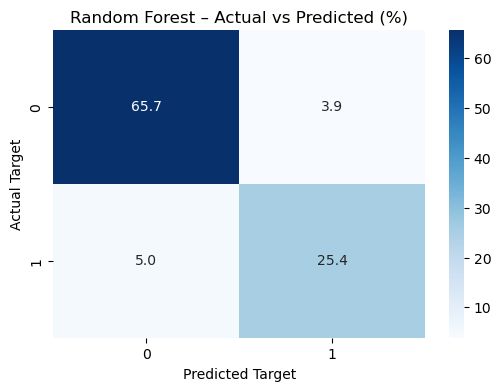

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)

# Normaliser til prosent
cm_percent = cm.astype("float") / cm.sum() * 100

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=[0, 1],  # Predicted
            yticklabels=[0, 1])  # Actual
plt.title("Random Forest – Actual vs Predicted (%)")
plt.ylabel("Actual Target")
plt.xlabel("Predicted Target")
plt.show()


In [18]:
# Hent transformeren for kategoriske features
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]

# Feature-navn for kategoriske
cat_feature_names = list(ohe.get_feature_names_out(["airport_group"]))

# Kombiner med numeriske
all_feature_names = cat_feature_names + num_cols
importances = rf_final.named_steps["clf"].feature_importances_

feat_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importance.head(15))

                          feature  importance
7                     flights_cnt    0.332520
17                   target_sched    0.279087
10                passenger_share    0.099451
9                    max_duration    0.078524
8                    avg_duration    0.060404
15                        hournum    0.022300
21               flights_cnt_next    0.021054
19              daily_flights_cnt    0.020551
22      mean(air_temperature P1D)    0.017289
20               flights_cnt_prev    0.017153
14                          month    0.015946
23  sum(precipitation_amount P1D)    0.014168
13                            dow    0.010310
1                 airport_group_B    0.001948
5                 airport_group_F    0.001741


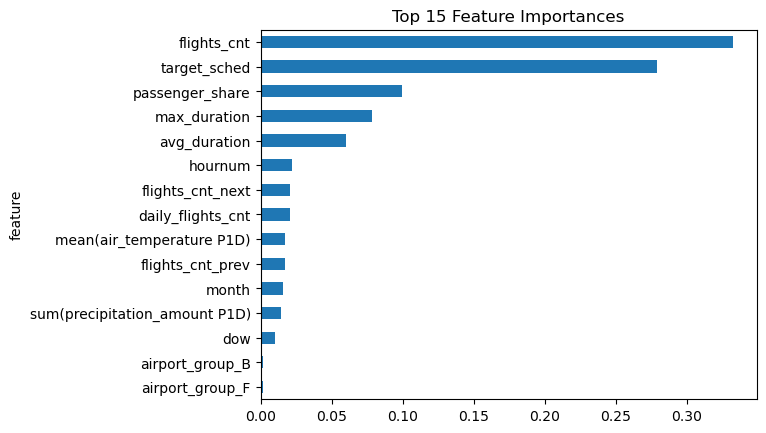

In [19]:
feat_importance.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

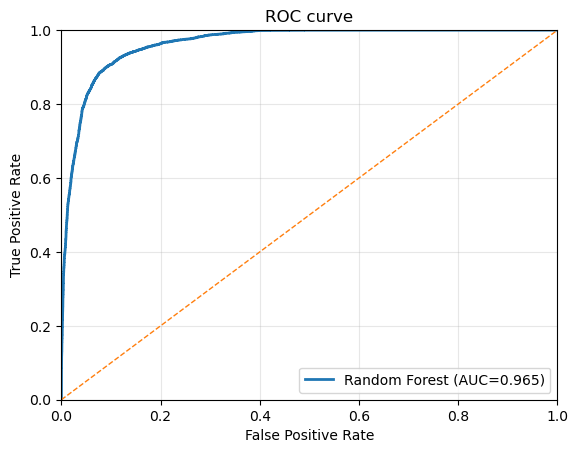

In [20]:
def plot_roc(y_true, y_proba, label="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, linewidth=2, label=f"{label} (AUC={score:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # tilfeldig baseline
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
plot_roc(y_test, pred_prob_test, label="Random Forest")

# Predikerer oktober 2025 med endelig modell

In [21]:
y_proba_oct = rf_final.predict_proba(X_pred)[:, 1]

In [22]:
pred

,airport_group,timestamp,target_sched,flights_cnt,avg_duration,max_duration,passenger_share,cargo_share,charter_share,airline,...,holiday,month,hournum,weekend,date,daily_flights_cnt,flights_cnt_prev,flights_cnt_next,mean(air_temperature P1D),sum(precipitation_amount P1D)
0,G,2025-10-01 03:00:00,1,4,26.25,35.0,1.0,0.0,0.0,WF,...,False,10,3,0,2025-10-01,34,0,0,8.6,0.0
1,B,2025-10-01 03:00:00,1,2,50.00,70.0,1.0,0.0,0.0,WF,...,False,10,3,0,2025-10-01,47,0,4,11.4,0.0
2,D,2025-10-01 03:00:00,0,0,0.00,0.0,0.0,0.0,0.0,NaN,...,False,10,3,0,2025-10-01,48,0,3,8.0,0.0
3,C,2025-10-01 03:00:00,0,0,0.00,0.0,0.0,0.0,0.0,NaN,...,False,10,3,0,2025-10-01,21,0,5,7.7,0.0
4,F,2025-10-01 03:00:00,0,0,0.00,0.0,0.0,0.0,0.0,NaN,...,False,10,3,0,2025-10-01,26,0,0,7.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,B,2025-10-31 00:00:00,0,0,0.00,0.0,0.0,0.0,0.0,NaN,...,False,10,0,0,2025-10-31,0,0,0,6.5,0.0
5022,C,2025-10-31 00:00:00,0,0,0.00,0.0,0.0,0.0,0.0,NaN,...,False,10,0,0,2025-10-31,0,0,0,2.6,0.8
5023,E,2025-10-31 00:00:00,0,0,0.00,0.0,0.0,0.0,0.0,NaN,...,False,10,0,0,2025-10-31,0,0,0,6.0,2.6
5024,A,2025-10-31 00:00:00,0,0,0.00,0.0,0.0,0.0,0.0,NaN,...,False,10,0,0,2025-10-31,0,0,0,5.5,1.3


In [23]:
pred_out = pred.copy()
pred_out["pred"] = y_proba_oct  # sannsynlighet for overlap (target_actual=1)
pred_out["pred"] = pred_out["pred"].round(3)


pred_out["hour"] = pred_out['hournum']

pred_out = pred_out.sort_values(["date", "hour"]).reset_index(drop=True)
pred_out = pred_out[["airport_group", "date", "hour", "pred"]]

pred_out.to_csv("../data/prediction_data/predict_oct2025_with_proba.csv", index=False)

pred_out

,airport_group,date,hour,pred
0,G,2025-10-01,3,0.915
1,B,2025-10-01,3,0.826
2,D,2025-10-01,3,0.046
3,C,2025-10-01,3,0.000
4,F,2025-10-01,3,0.000
...,...,...,...,...
5021,B,2025-10-31,0,0.000
5022,C,2025-10-31,0,0.000
5023,E,2025-10-31,0,0.000
5024,A,2025-10-31,0,0.000
